# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 8)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2, make_plots
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

devices = ["cuda:0", "cuda:0", "cuda:1", "cuda:2", "cuda:3",]
# devices = ["cpu"] * 5
device = torch.device(devices[0] if torch.cuda.is_available() else "cpu")
device1 = torch.device(devices[1] if torch.cuda.is_available() else "cpu")
device2 = torch.device(devices[2] if torch.cuda.is_available() else "cpu")
device3 = torch.device(devices[3] if torch.cuda.is_available() else "cpu")
device4 = torch.device(devices[4] if torch.cuda.is_available() else "cpu")

set_device(device)
print(get_device())

scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
set_global("gradient_clipping", 10)
# Use mixup in SSL training, Use UDA maybe
# os.path.join(get_global("models_dir"),)


cuda:0


In [2]:
import random
def get_preprocess_text():
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        text = translation(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        imtrans = image_views[imv]
        ag_idx = imv + 1
        def aug_sample(sample):
            sample["text_view_%s" % ag_idx] = preprocess_text(sample.original_text, identifier=sample.id)
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    return [get_view(0), get_view(1), get_view(2)]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=None,
                    train_image_transform=None,
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)





In [3]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.4, 0.5], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.4, 0.5], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_twitter": 0.75,"word_cutout": 0.5,
                      "one_third_cut": 0.2, "half_cut":0.0, "part_select": 0.2, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        if random.random() < 0.2:
            text = sentence_level(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        text = word_level(text, **kwargs)
        text = char_level(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        ag_idx = imv + 1
        def aug_sample(sample):
            sample["text_view_%s" % ag_idx] = preprocess_text(sample.original_text, identifier=sample.id)
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    return [get_view(0), get_view(1), get_view(2)]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)






In [4]:
data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
data['dev_unseen']["label"] = -1

df = pd.concat((data["train"],
                data['dev_unseen'],
                data["test"], data['test_unseen']))
df.shape


(12540, 4)

In [5]:

dataset = convert_dataframe_to_dataset(df, data["metadata"], True, additional_processors=get_views())

In [6]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01), 
                "vilbert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01), 
                "visual_bert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01),
                "mmbt_region": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01)},
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.1,
    word_masking_proba=0.15,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=1,
    bbox_copies=1,
    bbox_deletes=1,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.01,
    bbox_dropout=0.05,
    view_transforms=get_views(),
    view_loss_weight=0.1,
    devices=dict(lxmert=device1, vilbert=device4, 
                 visual_bert=device3, mmbt_region=device2),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)
# model = model.to(get_device())




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Overriding option config to projects/hateful_memes/configs/mmbt/with_features.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.features
Overriding option evaluation.predict to true


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


In [7]:
del model.vilbert.model.classifier
del model.visual_bert.model.classifier
del model.mmbt_region.model.classifier


In [8]:
# torch.save(model.lxmert.state_dict(), os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth"))
model.lxmert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth")))

# torch.save(model.mmbt_region.state_dict(), os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth"))
model.mmbt_region.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth")))


# torch.save(model.visual_bert.state_dict(), os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth"))
model.visual_bert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth")))

# torch.save(model.vilbert.state_dict(), os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth"))
model.vilbert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth")))




<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

# Unimodal MLM

In [9]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None, mlm_loss_weight=0.5,)
# mlm_model = mlm_model.to(get_device())
# mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
# mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
# mlm_model = mlm_model.to(get_device())


In [10]:
# torch.save(mlm_model.state_dict(), "mlm-model-v2-view-1.pth")



In [ ]:

lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": True,},
        "visual_bert": {"finetune": True,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlm": {"finetune": True},
}
epochs = 1
batch_size = 8
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=2e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=8, plot=True,
                                     sampling_policy=None, class_weights=None)




Autocast =  True Epochs =  1 Divisor = 1 Examples = 12540 Batch Size =  8
Training Samples =  12540 Weighted Sampling =  False Num Batches =  1568 Accumulation steps =  8


FeatureExtractor : Loaded Model...
Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...
Exception for:  keyboard | Original Text You see it? I do not see it Final Text You see it? I do not see it | ['keyboard' 'char_substitute'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | Original Text Do you see?? Ido not see it Final Text Do you see?? Ido not see it | ['keyboard'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | Original Text gas on its own Final Text gas on its own | ['keyboard'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | Original Text It's not rape, it's a fight hug. Final Text It ' s not ra%e, it ' s a f%ght hug. | ['char_substitute' 'keyboard'] argument of t

In [11]:
clean_memory()

In [11]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

defaultdict(float,
            {'called': 50160.0,
             'hit': 50160.0,
             'read_time': 0.0022944484853964333})

defaultdict(float,
            {'called': 50160.0,
             'hit': 50160.0,
             'read_time': 0.0018967521930043489})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


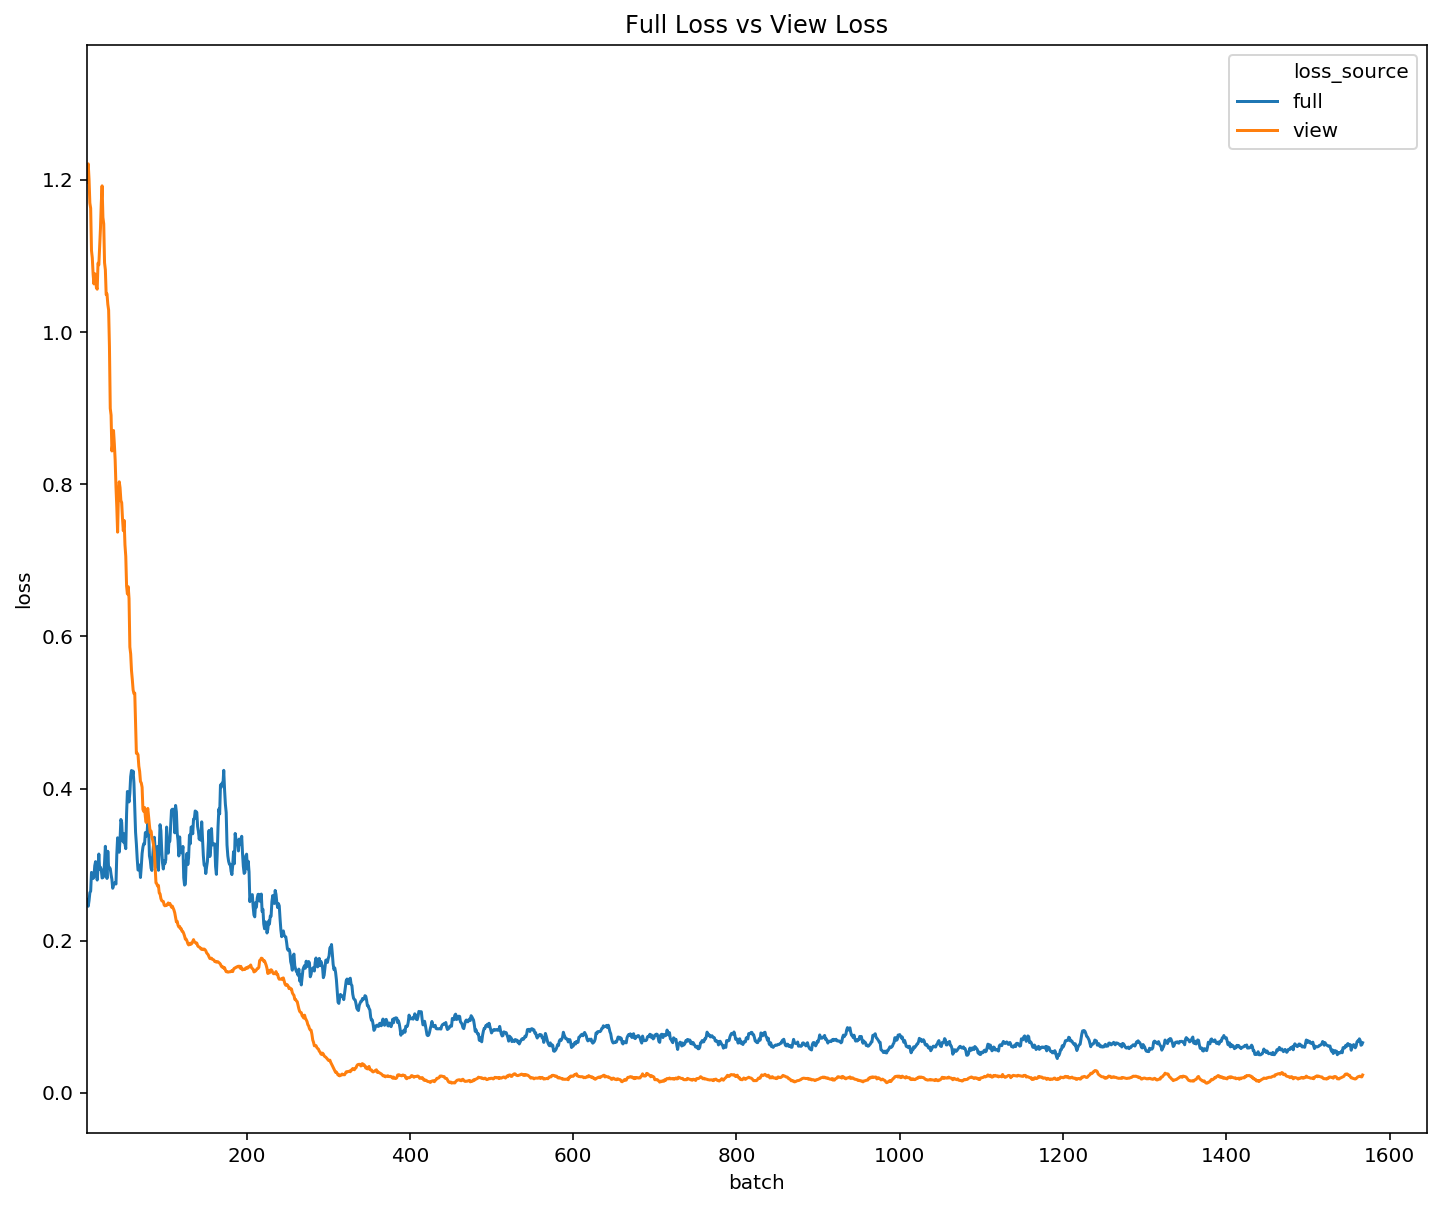

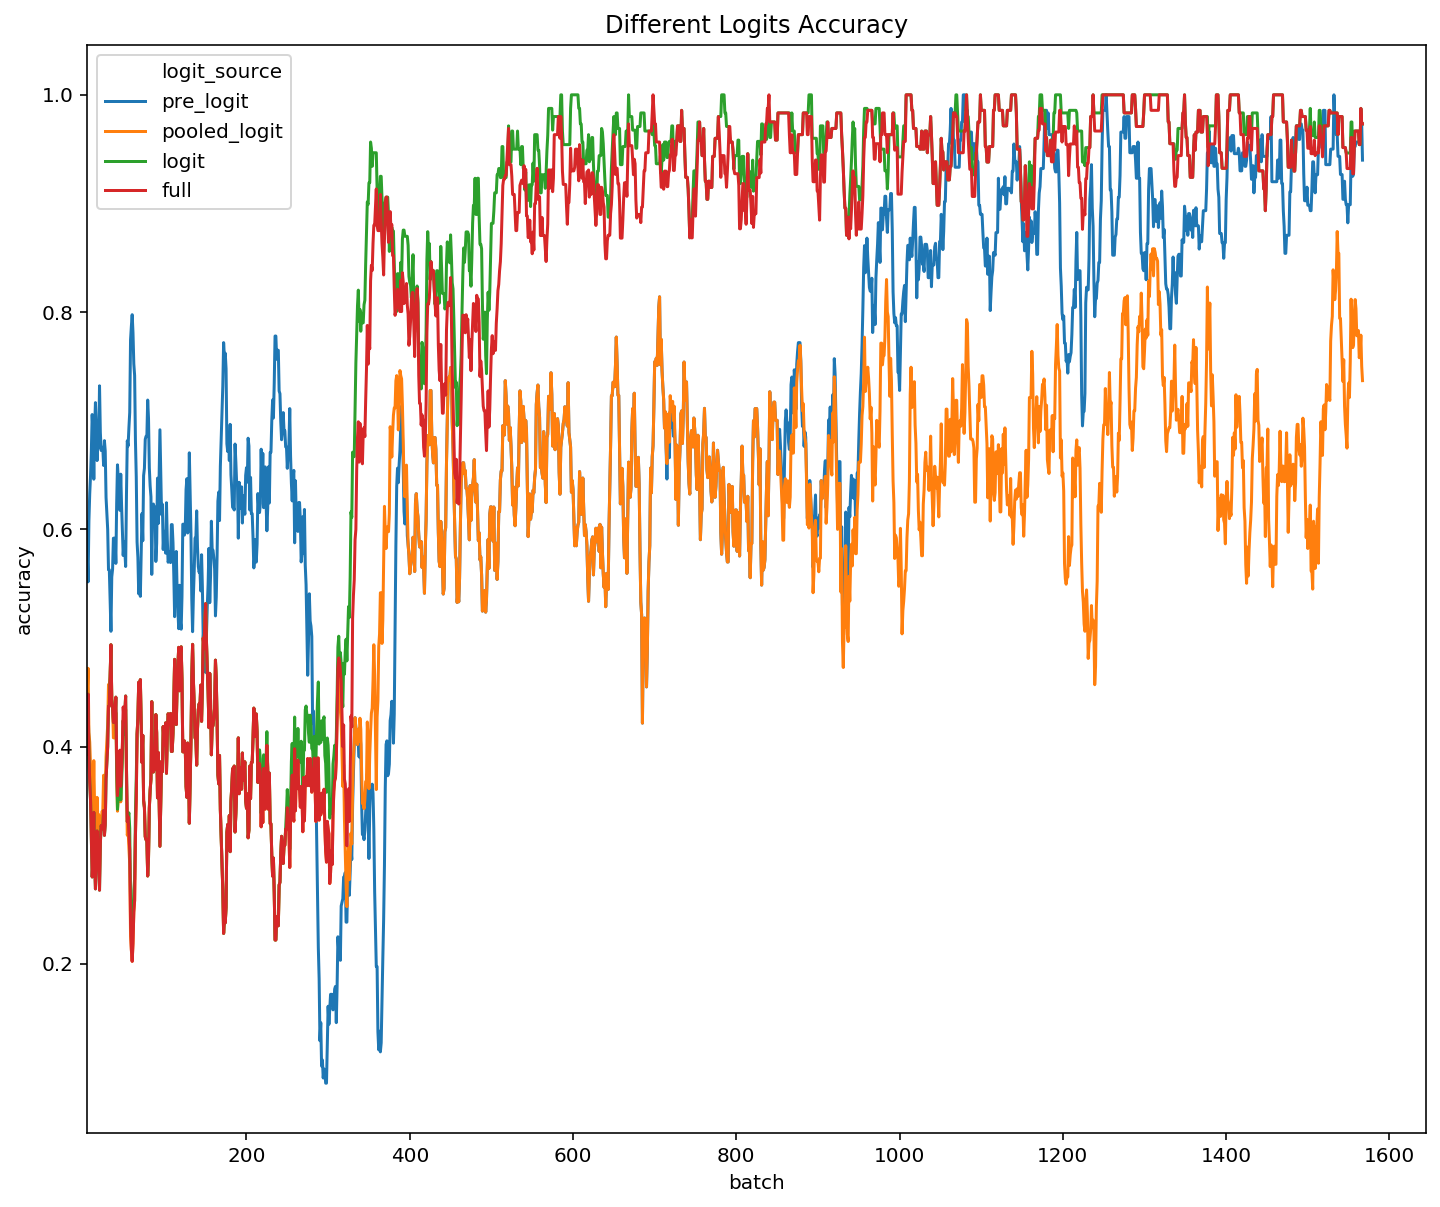

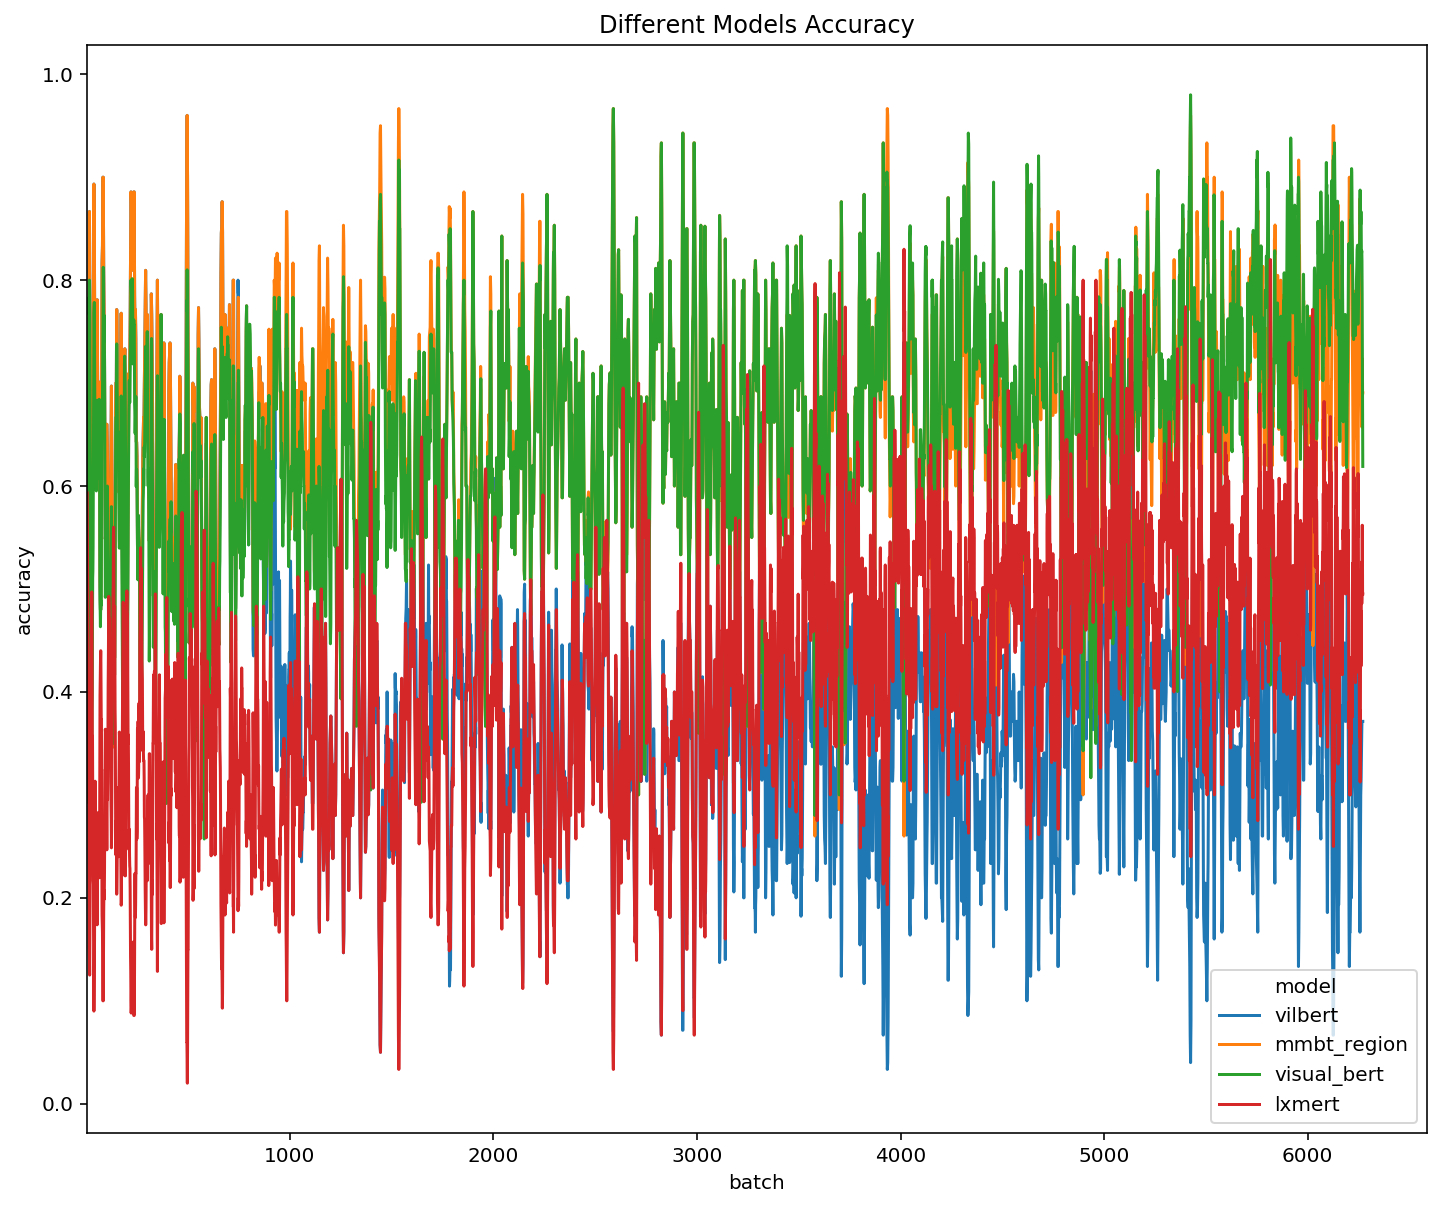

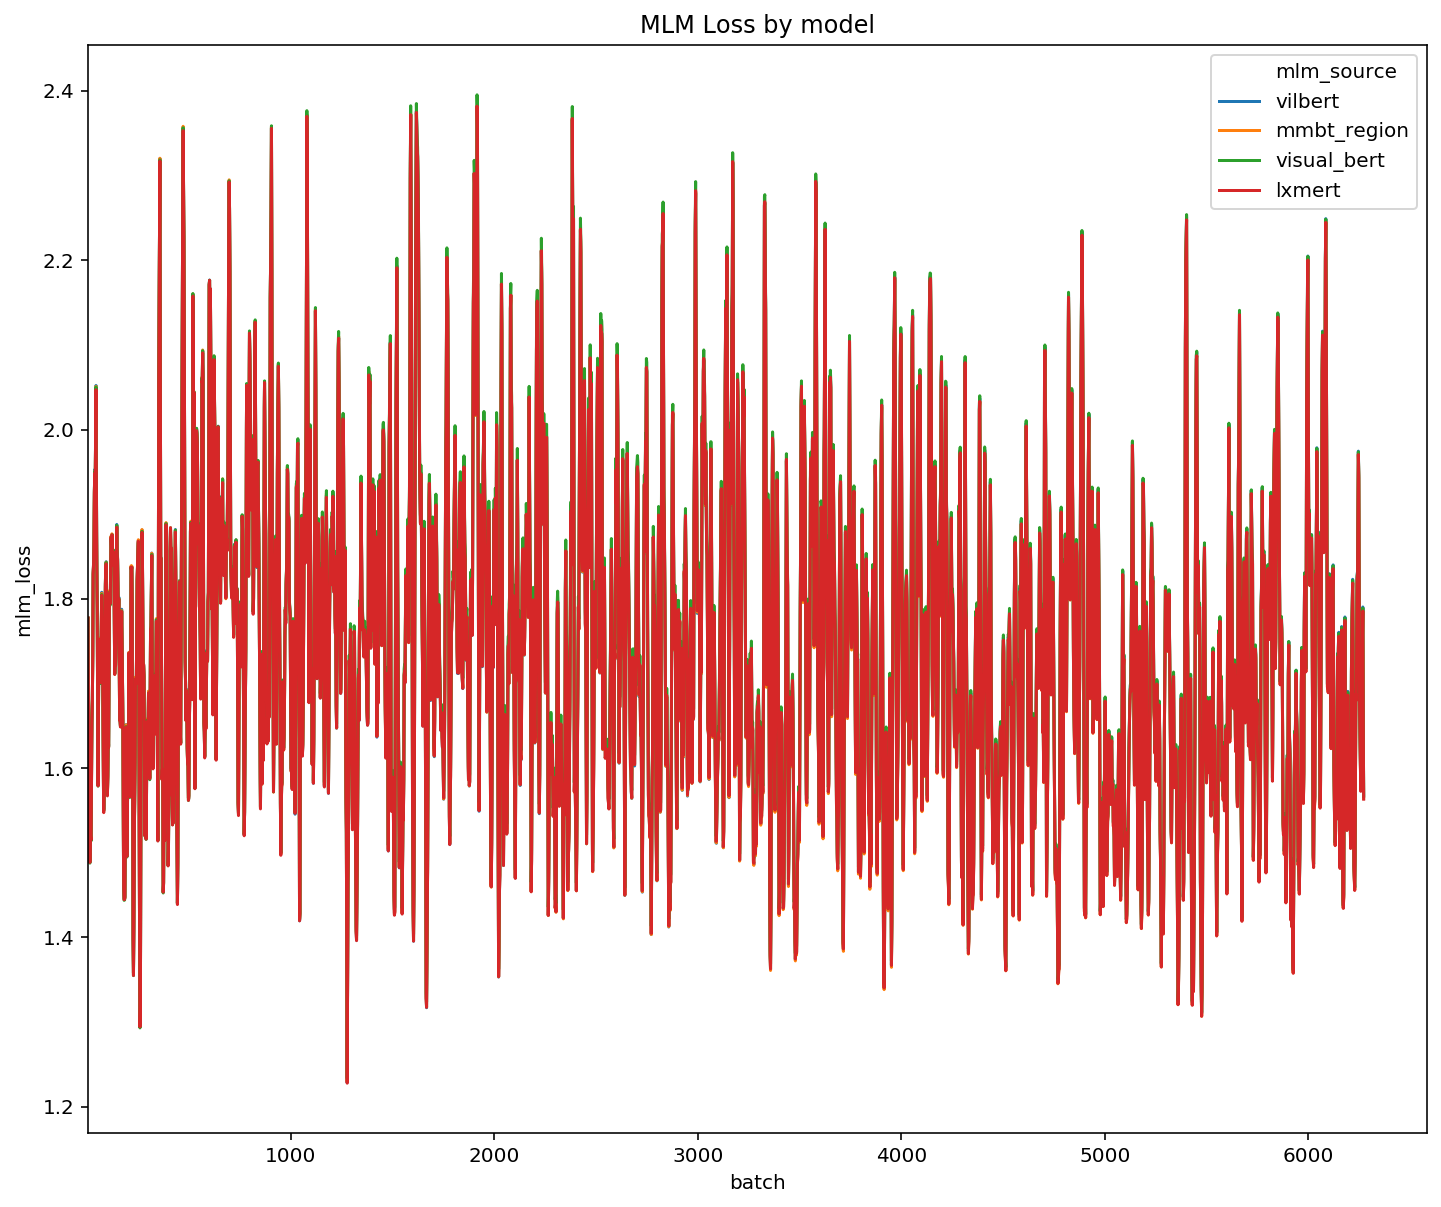

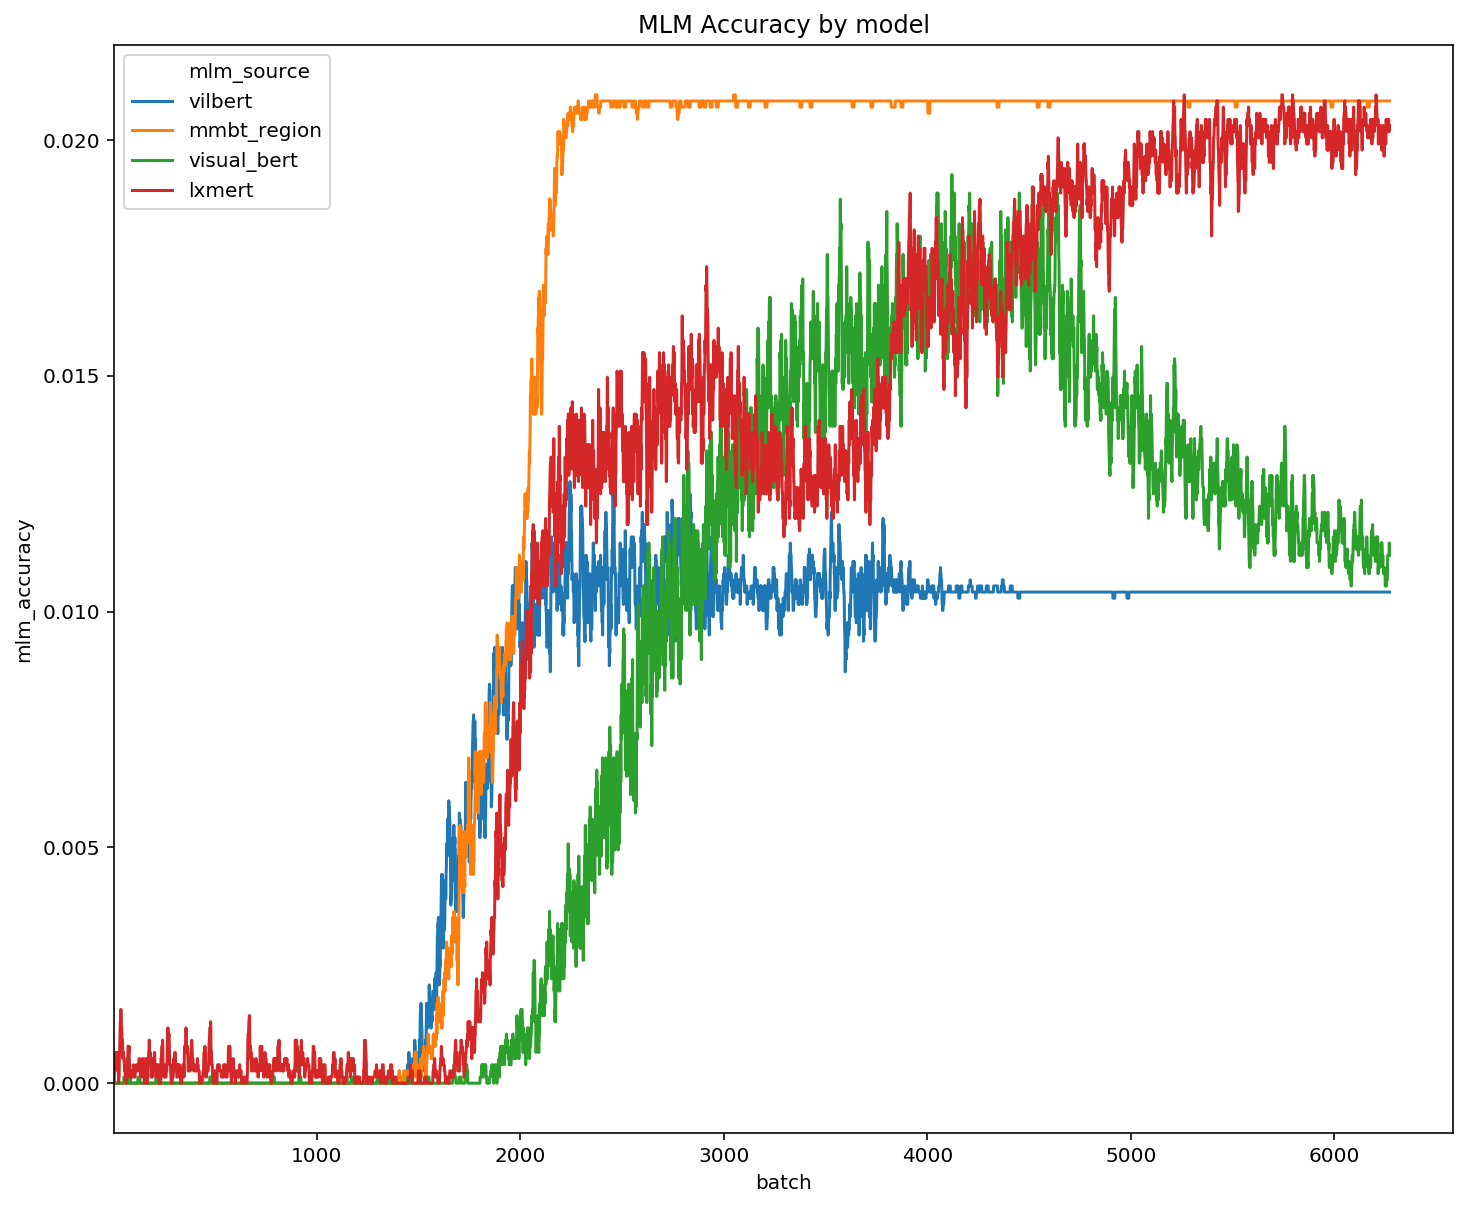

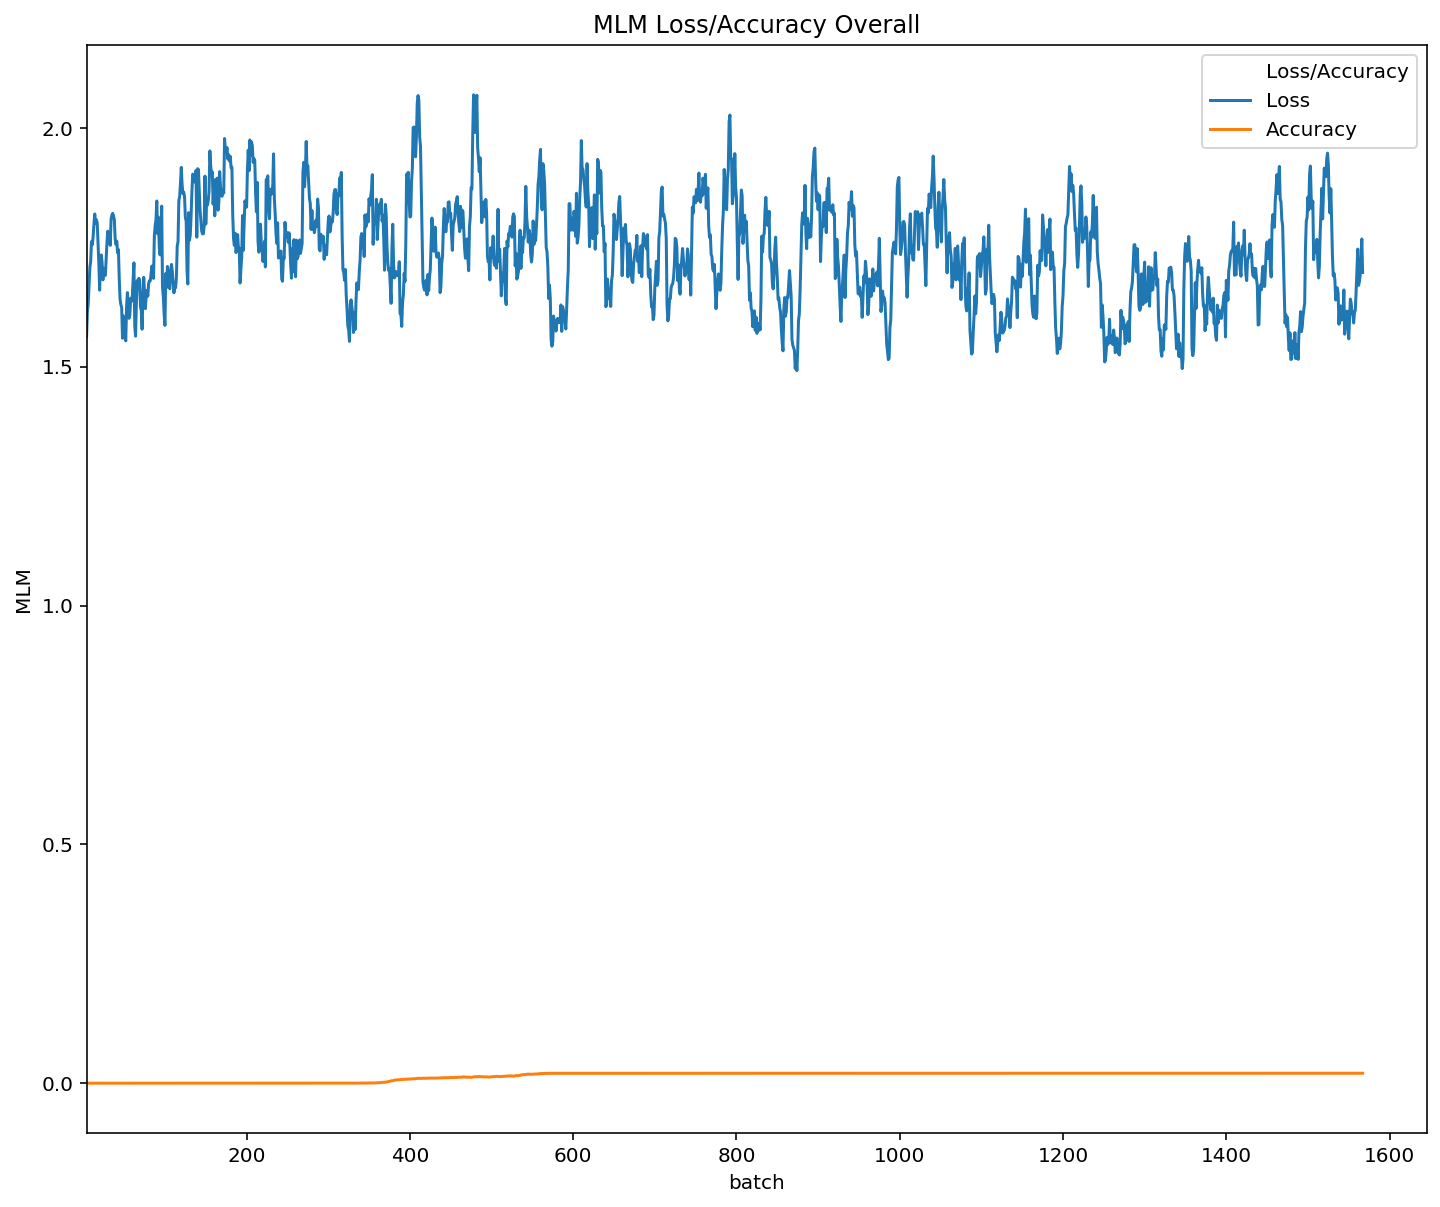

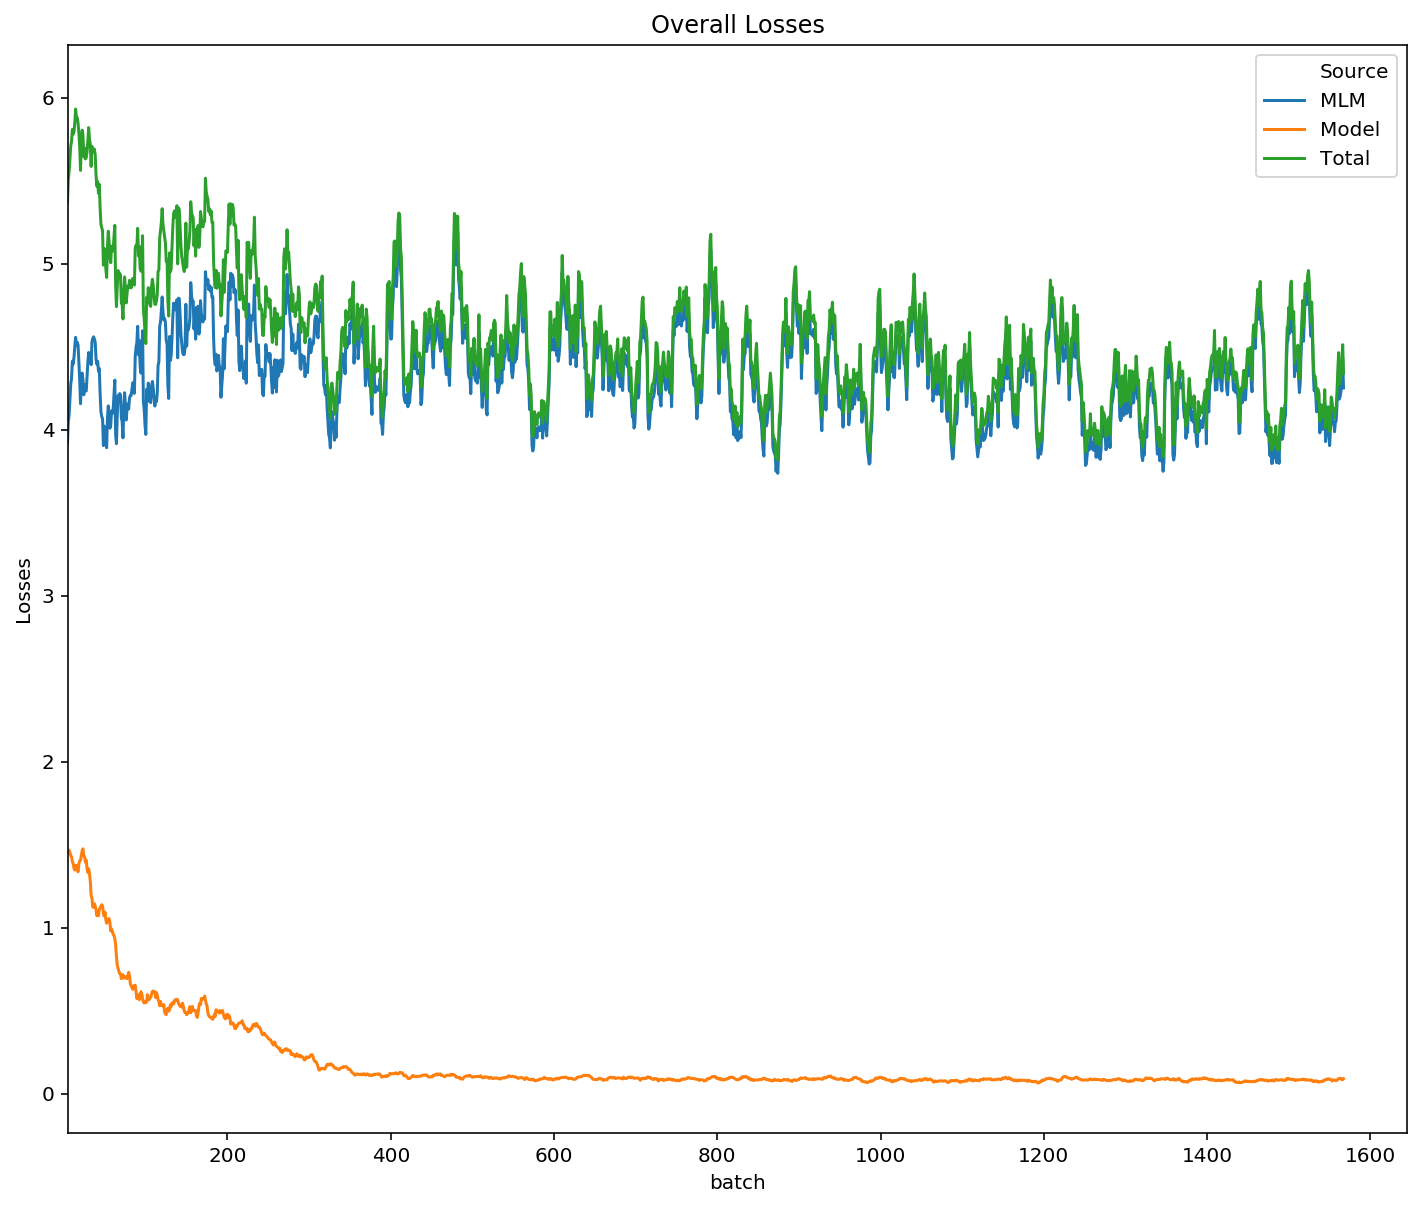

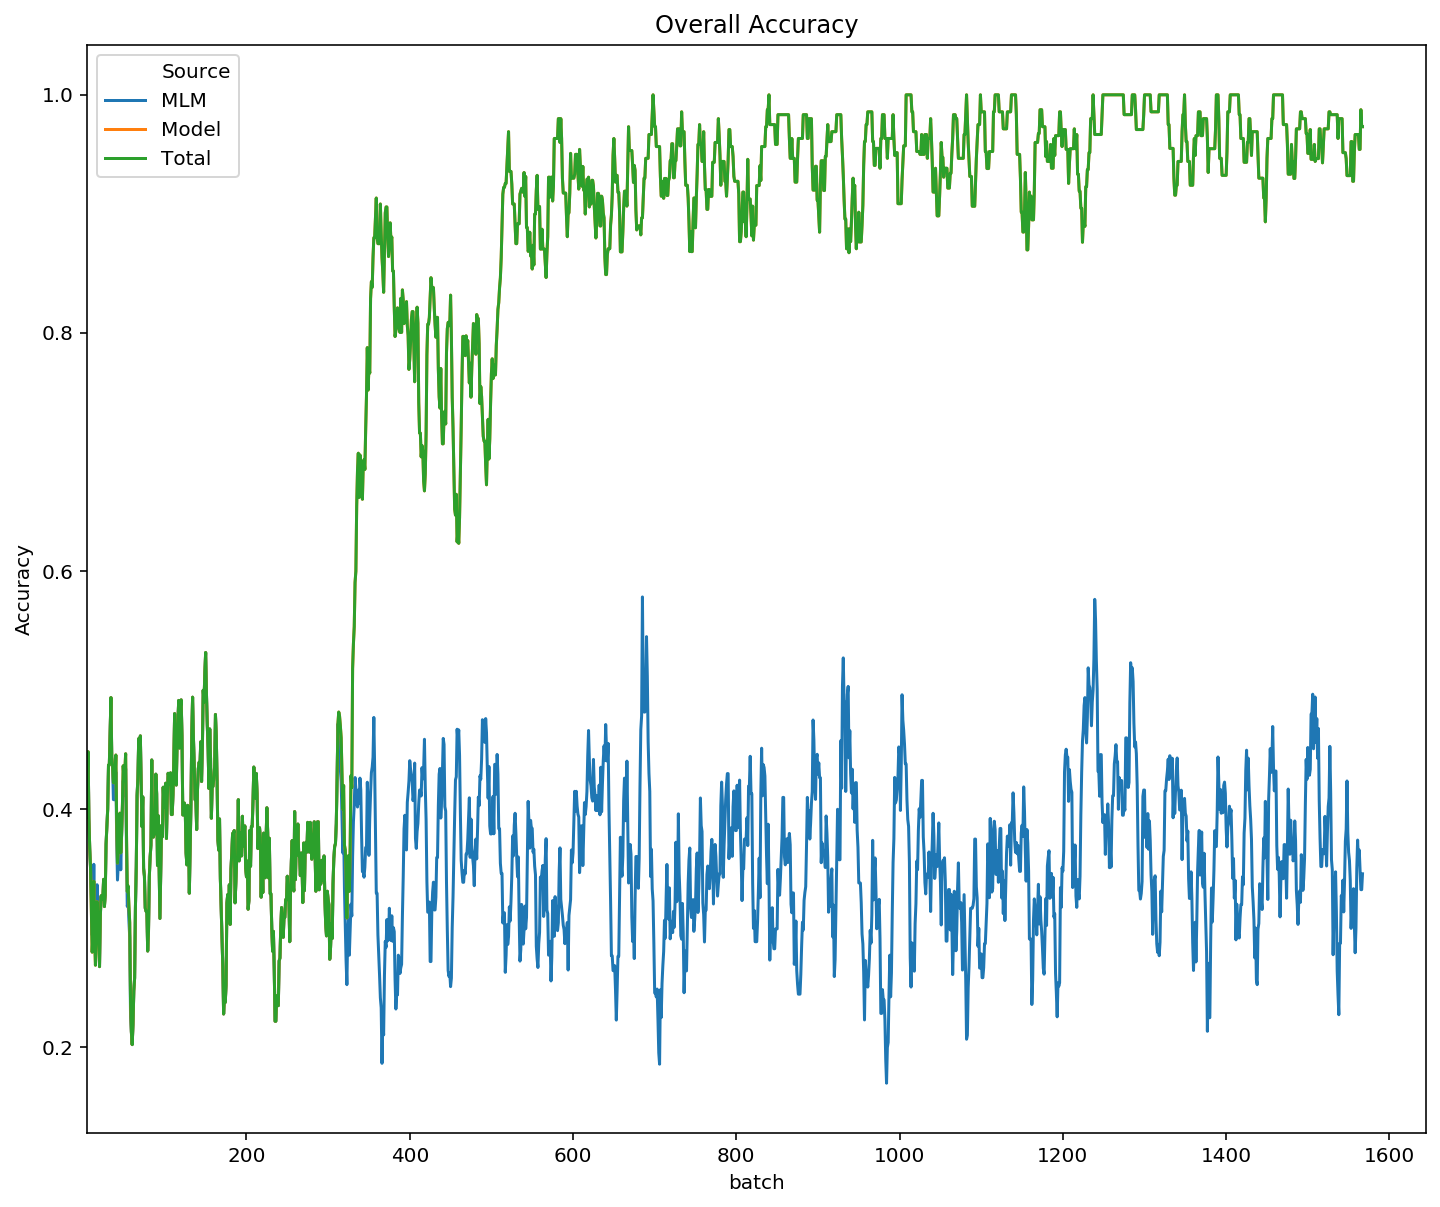

In [12]:
make_plots(model, mlm_model, logy=False, exclude_from_start=5, smoothing=10)

# Single Eval

## Validate

In [13]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.410 0.480     0   0
1      0.477 0.560     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.493,"[0.5065484046936035, 0.4934515953063965]",0,1,0.433,"[0.5669854283332825, 0.4330146312713623]",0,0,0.528,"[0.4724733829498291, 0.5275265574455261]",1,1
1,0.416,"[0.5836568474769592, 0.41634318232536316]",0,0,0.531,"[0.4685852825641632, 0.5314146876335144]",1,1,0.548,"[0.45195093750953674, 0.5480490922927856]",1,1
2,0.560,"[0.4395037591457367, 0.5604962110519409]",1,1,0.416,"[0.5843064188957214, 0.41569358110427856]",0,0,0.494,"[0.505766749382019, 0.49423328042030334]",0,1
3,0.496,"[0.503805935382843, 0.49619409441947937]",0,1,0.430,"[0.5702592134475708, 0.4297407865524292]",0,0,0.521,"[0.4794553816318512, 0.5205445885658264]",1,1
4,0.411,"[0.5890397429466248, 0.41096028685569763]",0,0,0.542,"[0.4582419693470001, 0.5417580604553223]",1,1,0.477,"[0.5233150124549866, 0.4766850173473358]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,253,0,253.000,100.000
1,43,204,247.000,82.000
Predicted Counts,296,204,500.000,nan
Precision %,85,100,nan,nan


scores =  {'map': '1.0000', 'acc': '0.9140', 'auc': '1.0000'}


([0.9999674812610767, 0.914, 0.9999679953913364],
 (array([0.85472973, 1.        ]),
  array([1.        , 0.82591093]),
  array([0.92167577, 0.90465632]),
  array([253, 247])))

In [18]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False)
validate(model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.410 0.528     0   1
1      0.425 0.538     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5389000177383423, 0.4610999822616577]",0,0,0.489,"[0.5114263296127319, 0.4885736405849457]",0,0,0.446,"[0.5540364980697632, 0.4459635019302368]",0,0
1,0.459,"[0.5413897037506104, 0.45861032605171204]",0,1,0.433,"[0.5668643116950989, 0.43313562870025635]",0,1,0.440,"[0.5601358413696289, 0.4398641884326935]",0,0
2,0.509,"[0.4912693202495575, 0.5087306499481201]",1,1,0.474,"[0.5262804627418518, 0.4737195372581482]",0,1,0.469,"[0.531103253364563, 0.468896746635437]",0,1
3,0.494,"[0.5062372088432312, 0.4937628209590912]",0,0,0.469,"[0.531242311000824, 0.4687577486038208]",0,0,0.426,"[0.5744434595108032, 0.425556480884552]",0,0
4,0.442,"[0.5584234595298767, 0.4415765404701233]",0,1,0.442,"[0.5575517416000366, 0.44244828820228577]",0,0,0.475,"[0.5247483849525452, 0.47525161504745483]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,244,9,253.000,96.000
1,213,34,247.000,13.000
Predicted Counts,457,43,500.000,nan
Precision %,53,79,nan,nan


scores =  {'map': '0.7305', 'acc': '0.5560', 'auc': '0.7721'}


([0.7304913070922474, 0.556, 0.7720791794018338],
 (array([0.53391685, 0.79069767]),
  array([0.96442688, 0.13765182]),
  array([0.68732394, 0.23448276]),
  array([253, 247])))

In [16]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.410 0.479     0   0
1      0.479 0.557     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.507,"[0.49311235547065735, 0.506887674331665]",1,1,0.430,"[0.5704945921897888, 0.4295053780078888]",0,0,0.422,"[0.5782730579376221, 0.4217269718647003]",0,0
1,0.416,"[0.5837998986244202, 0.4162001311779022]",0,0,0.416,"[0.5839163661003113, 0.4160836637020111]",0,0,0.424,"[0.575544536113739, 0.4244553744792938]",0,0
2,0.501,"[0.499242901802063, 0.5007570385932922]",1,1,0.417,"[0.5831501483917236, 0.41684985160827637]",0,0,0.434,"[0.565926730632782, 0.434073269367218]",0,0
3,0.421,"[0.5788815021514893, 0.42111852765083313]",0,0,0.507,"[0.49291664361953735, 0.5070833563804626]",1,1,0.426,"[0.5738827586174011, 0.4261172115802765]",0,0
4,0.417,"[0.5832109451293945, 0.4167890250682831]",0,0,0.501,"[0.49931085109710693, 0.5006891489028931]",1,1,0.422,"[0.5780776739120483, 0.42192235589027405]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,340,0,340.000,100.000
1,38,162,200.000,81.000
Predicted Counts,378,162,540.000,nan
Precision %,89,100,nan,nan


scores =  {'map': '1.0000', 'acc': '0.9296', 'auc': '1.0000'}


([0.9999751243781094, 0.9296296296296296, 0.999985294117647],
 (array([0.8994709, 1.       ]),
  array([1.  , 0.81]),
  array([0.94707521, 0.89502762]),
  array([340, 200])))

In [17]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False)
validate(model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.419 0.527     0   1
1      0.425 0.536     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.438,"[0.5620490312576294, 0.4379509389400482]",0,1,0.443,"[0.5568691492080688, 0.44313085079193115]",0,0,0.496,"[0.5040863752365112, 0.49591368436813354]",0,0
1,0.434,"[0.5664786100387573, 0.4335213601589203]",0,0,0.437,"[0.5627672076225281, 0.4372328221797943]",0,1,0.452,"[0.5478836297988892, 0.45211634039878845]",0,0
2,0.454,"[0.5460318922996521, 0.4539681375026703]",0,0,0.423,"[0.5771527290344238, 0.4228472113609314]",0,0,0.453,"[0.5470486879348755, 0.45295122265815735]",0,0
3,0.472,"[0.527653694152832, 0.4723462462425232]",0,1,0.506,"[0.49437159299850464, 0.5056284070014954]",1,1,0.476,"[0.5238088369369507, 0.4761911630630493]",0,1
4,0.448,"[0.5515027642250061, 0.4484972357749939]",0,0,0.434,"[0.5656238794326782, 0.4343760907649994]",0,1,0.495,"[0.504757285118103, 0.495242714881897]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,328,12,340.000,96.000
1,178,22,200.000,11.000
Predicted Counts,506,34,540.000,nan
Precision %,64,64,nan,nan


scores =  {'map': '0.5861', 'acc': '0.6481', 'auc': '0.7369'}


([0.5861158854338385, 0.6481481481481481, 0.7369117647058824],
 (array([0.64822134, 0.64705882]),
  array([0.96470588, 0.11      ]),
  array([0.77541371, 0.18803419]),
  array([340, 200])))

## Predict

In [19]:
preds = predict(mlm_model, data, batch_size, competition_phase=1)


,id,proba,label
0,16395,0.461,0
1,37405,0.472,0
2,94180,0.467,0
3,54321,0.450,0
4,97015,0.473,0
...,...,...,...
995,3869,0.447,0
996,23817,0.444,0
997,56280,0.452,0
998,29384,0.449,0


In [ ]:
preds = predict(model, data, batch_size, competition_phase=1)


In [25]:
preds.to_csv("submission_phase_1.csv", index=False)

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
